In [115]:
# 导入必要的库
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

In [116]:
df_2020 = pd.read_csv('user_2020.csv')

In [117]:
df_2020.head(5)

,user_id,order_no,paid_cash,create_date
0,452485,202302160072007,300.0,2023/2/16
1,452494,202101090070492,9.0,2021/1/9
2,452494,202101130075871,90.0,2021/1/13
3,452498,202202060858935,300.0,2022/2/6
4,452498,202212100040463,99.0,2022/12/10


In [118]:
df_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76843 entries, 0 to 76842
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      76843 non-null  int64  
 1   order_no     76843 non-null  int64  
 2   paid_cash    76843 non-null  float64
 3   create_date  76843 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 2.3+ MB


In [119]:
# 转换‘建单日期’为 日期格式

df_2020['create_date'] = pd.to_datetime(df_2020['create_date'])

# 计算最大日期为’今天‘的日期
current_date = df_2020['create_date'].max() + pd.to_timedelta(1, 'D')

In [120]:
# 计算每个用户的 Recency、Frequency、Monetary 值

rfm = df_2020.groupby('user_id').agg({
    'create_date': lambda x: (current_date - x.max()).days,# Rececny
    'order_no': 'count', # Frequency
    'paid_cash': 'sum'
}).rename(columns={
    'create_date': 'Recency',
    'order_no': 'Frequency',
    'paid_cash': 'Monetary'
})

In [121]:
rfm.head(5)

,Recency,Frequency,Monetary
user_id,,,
452485,203,1,300.0
452494,967,2,99.0
452498,271,7,1488.0
452500,899,2,26.0
452501,520,1,99.0


In [122]:
# 数据预处理
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# 使用优化的参数进行聚类
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=150,
    min_samples=3, 
    metric='euclidean', 
    cluster_selection_epsilon=0.1, 
    alpha=1.5, 
    cluster_selection_method='eom', 
    algorithm='best')

clusterer.fit(rfm_scaled)
rfm['Cluster'] = pd.Series(clusterer.labels_, index=rfm.index)

# 查看结果
print(rfm['Cluster'].value_counts())

 9     4956
-1     2684
 11    2249
 10    1333
 8      834
 5      544
 4      488
 1      474
 0      334
 2      285
 7      172
 3      158
 6      153
Name: Cluster, dtype: int64


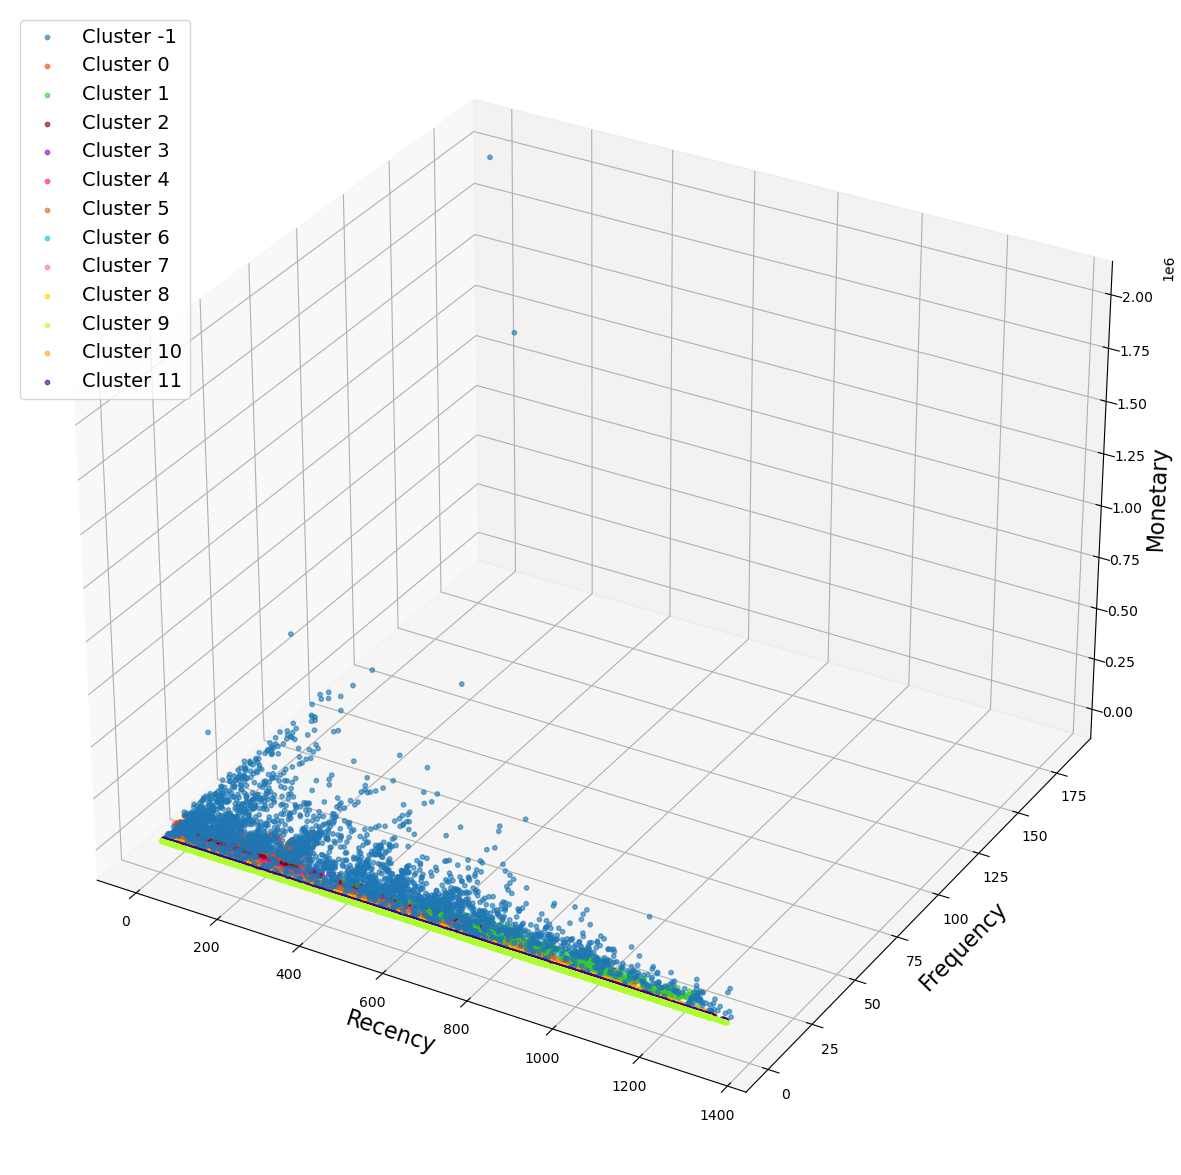

In [123]:
# 使用更为鲜明的颜色组合
colors = [
    "#1f77b4", "#ff4500", "#32cd32", "#8b0000", "#9400d3",
    "#ff1493", "#d2691e", "#00ced1", "#ff69b4", "#ffd700",
    "#adff2f", "#ffa500", "#4b0082"
]

# 进一步增加透明度
alpha_value = 0.6

# 保持点的大小
sizes = {cluster: 10 for cluster in rfm['Cluster'].unique()}

fig = plt.figure(figsize=(20, 15))
dx = fig.add_subplot(111, projection='3d')

for i, label in enumerate(sorted(rfm['Cluster'].unique())):
    dx.scatter(rfm[rfm.Cluster == label].Recency,
               rfm[rfm.Cluster == label].Frequency,
               rfm[rfm.Cluster == label].Monetary,
               c=[colors[i]],
               label='Cluster ' + str(label),
               s=sizes[label], alpha=alpha_value)

dx.set_xlabel('Recency', fontsize=16)
dx.set_ylabel('Frequency', fontsize=16)
dx.set_zlabel('Monetary', fontsize=16)
dx.legend(fontsize=14, loc='upper left')
dx.grid(True)  # 保持网格
plt.show()

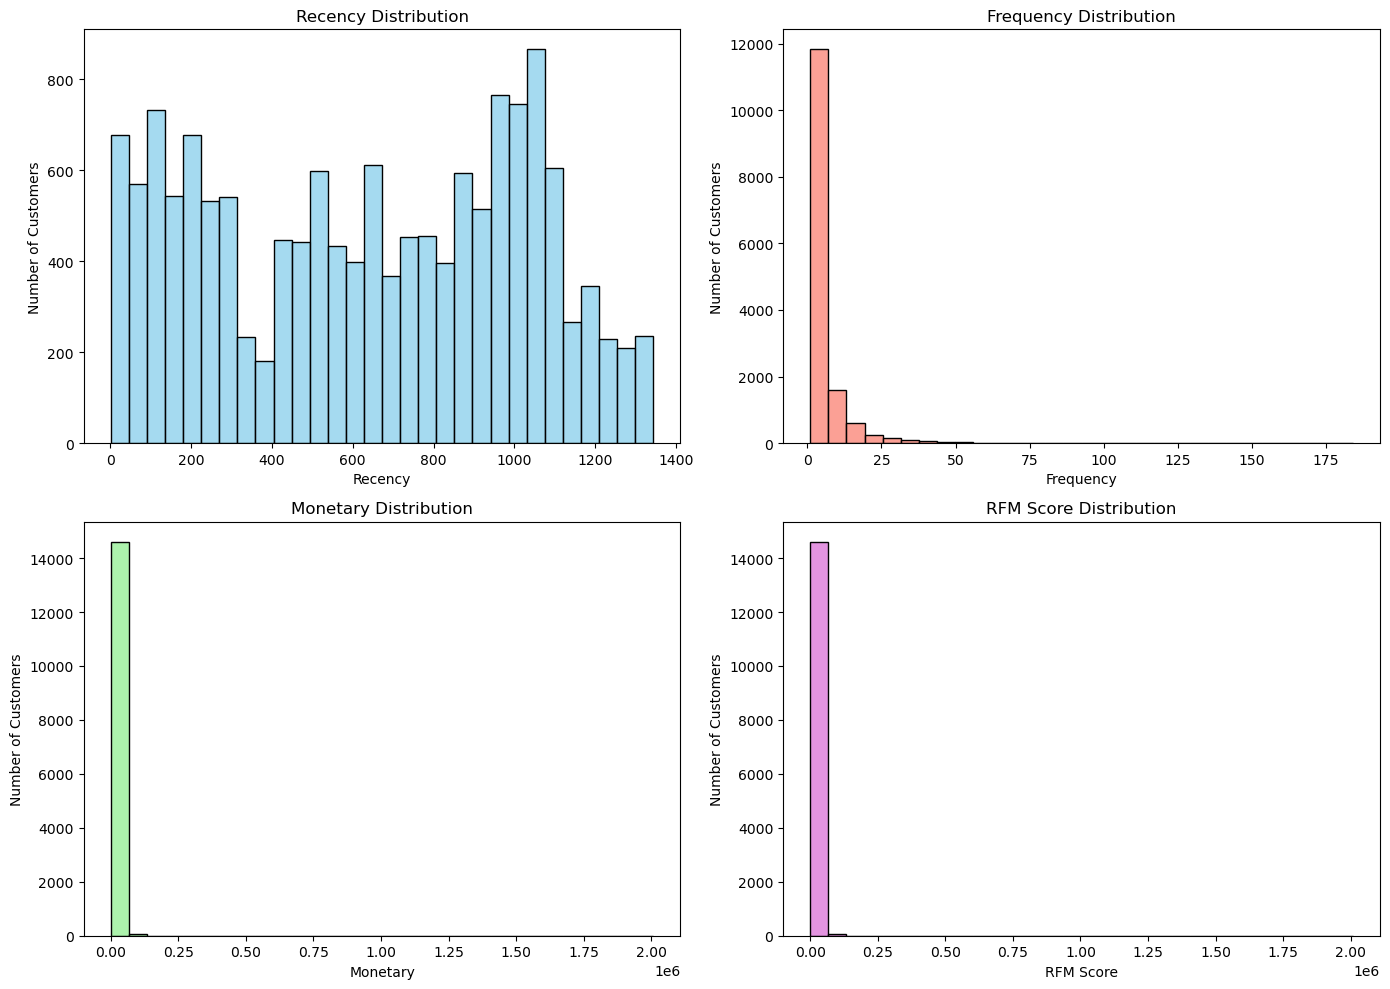

In [124]:
# 创建图形
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Recency分布图
sns.histplot(rfm['Recency'], kde=False, ax=ax[0, 0], bins=30, color='skyblue')
ax[0, 0].set_title('Recency Distribution')
ax[0, 0].set_xlabel('Recency')
ax[0, 0].set_ylabel('Number of Customers')

# Frequency分布图
sns.histplot(rfm['Frequency'], kde=False, ax=ax[0, 1], bins=30, color='salmon')
ax[0, 1].set_title('Frequency Distribution')
ax[0, 1].set_xlabel('Frequency')
ax[0, 1].set_ylabel('Number of Customers')

# Monetary分布图
sns.histplot(rfm['Monetary'], kde=False, ax=ax[1, 0], bins=30, color='lightgreen')
ax[1, 0].set_title('Monetary Distribution')
ax[1, 0].set_xlabel('Monetary')
ax[1, 0].set_ylabel('Number of Customers')

# RFM得分分布图 (需要计算RFM得分)
rfm['RFM_Score'] = rfm['Recency'] + rfm['Frequency'] + rfm['Monetary']
sns.histplot(rfm['RFM_Score'], kde=False, ax=ax[1, 1], bins=30, color='orchid')
ax[1, 1].set_title('RFM Score Distribution')
ax[1, 1].set_xlabel('RFM Score')
ax[1, 1].set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()

In [125]:
import datetime as dt
from scipy import stats
import jenkspy
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

r_breaks = jenkspy.jenks_breaks(rfm['Recency'], n_classes=4)
f_breaks = jenkspy.jenks_breaks(rfm['Frequency'], n_classes=4)
m_breaks = jenkspy.jenks_breaks(rfm['Monetary'], n_classes=4)
jenks_spread = pd.DataFrame(list(zip(r_breaks, f_breaks, m_breaks)), 
                      columns=['J_Recency','J_Frequency', 'J_Monetary'],
                     index = ['min', 'first_part','second_part','third_part', 'max'])
jenks_spread

,J_Recency,J_Frequency,J_Monetary
min,1,1,0.00
first_part,345,6,17401.03
second_part,681,19,356200.00
third_part,963,45,1213088.05
max,1344,184,2007926.01


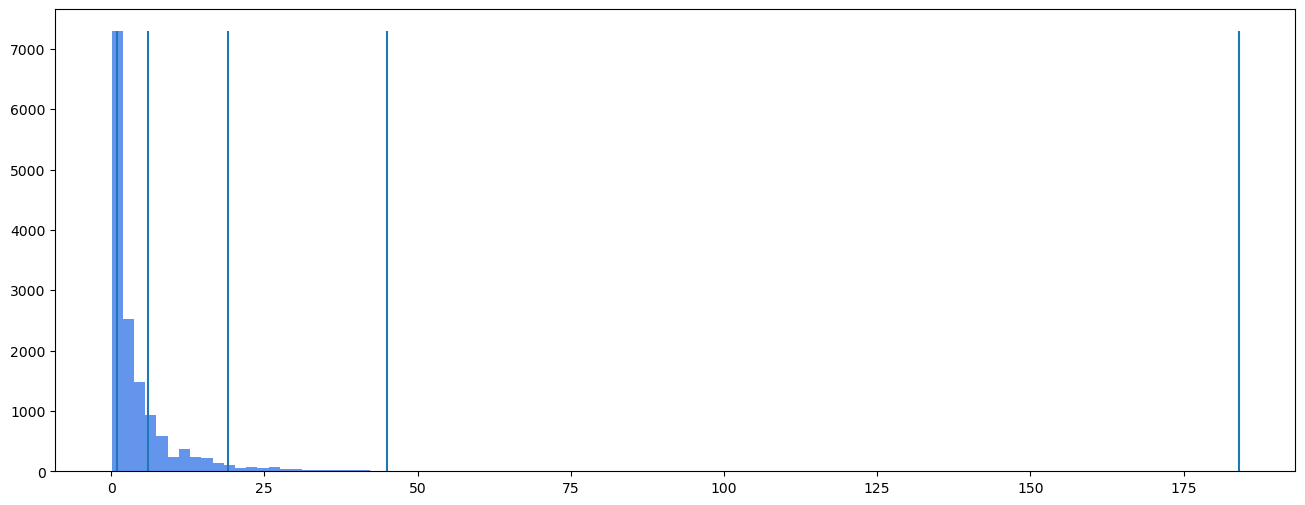

In [126]:
# 可视化
plt.figure(figsize = (16,6))
hist = plt.hist(rfm['Frequency'], bins=100,align='left', color='cornflowerblue')
for b in f_breaks:
    plt.vlines(b, ymin=0, ymax = max(hist[0]))

In [127]:
# 获取总金额最大的 TOP50 数据
top_50_data = rfm.sort_values(by='Monetary', ascending=False).head(50)
top_50_data


,Recency,Frequency,Monetary,Cluster,RFM_Score
user_id,,,,,
519994,3,184,2007926.01,-1,2008113.01
491876,74,181,1213088.05,-1,1213343.05
478222,91,52,666782.00,-1,666925.00
542682,13,24,356200.00,-1,356237.00
487648,137,11,121000.00,-1,121148.00
475437,283,15,117480.00,-1,117778.00
457124,265,106,116287.26,-1,116658.26
538196,352,19,107332.80,-1,107703.80
467601,29,80,98347.22,-1,98456.22


In [128]:
filtered_rfm = rfm[rfm['Monetary'] <= 40000]

In [129]:
filtered_rfm.head()

,Recency,Frequency,Monetary,Cluster,RFM_Score
user_id,,,,,
452485,203,1,300.0,9,504.0
452494,967,2,99.0,11,1068.0
452498,271,7,1488.0,7,1766.0
452500,899,2,26.0,11,927.0
452501,520,1,99.0,9,620.0


In [130]:
# 数据预处理
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(filtered_rfm[['Recency', 'Frequency', 'Monetary']])

# 使用优化的参数进行聚类
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=200,
    min_samples=5, 
    metric='euclidean', 
    cluster_selection_epsilon=0.13, 
    alpha=5.0,
    cluster_selection_method='eom',
    algorithm='best')
clusterer.fit(rfm_scaled)
filtered_rfm['Cluster'] = pd.Series(clusterer.labels_, index=filtered_rfm.index)

# 查看结果
print(filtered_rfm['Cluster'].value_counts())

 7    4953
-1    2257
 6    2237
 8    1299
 0     858
 9     830
 5     533
 4     415
 3     309
 2     270
 1     200
Name: Cluster, dtype: int64


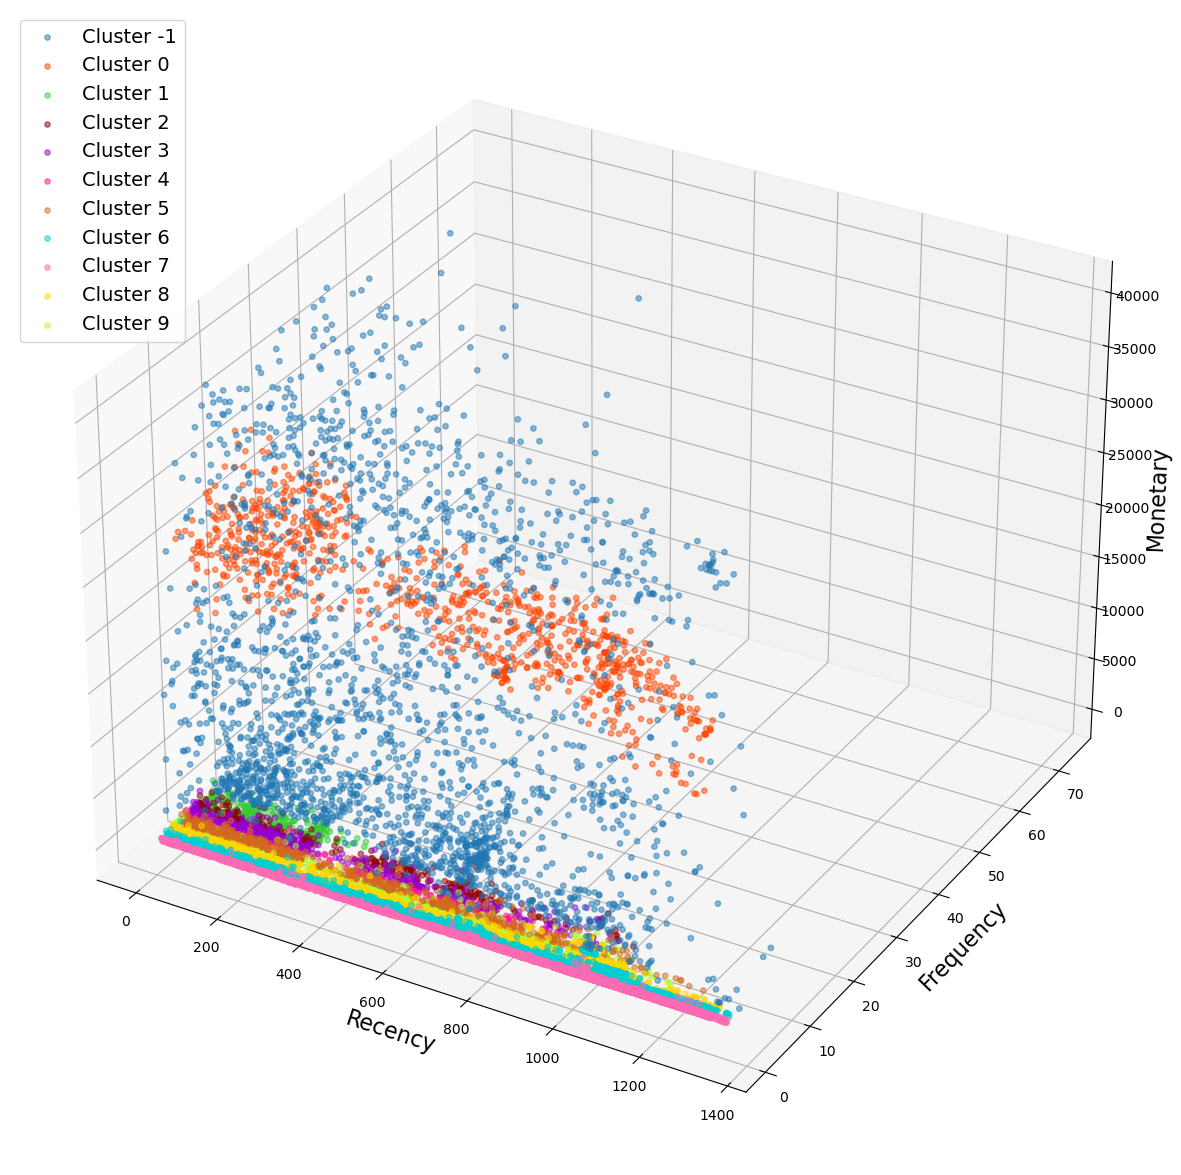

In [131]:
# 使用更为鲜明的颜色组合
colors = [
    "#1f77b4", "#ff4500", "#32cd32", "#8b0000", "#9400d3",
    "#ff1493", "#d2691e", "#00ced1", "#ff69b4", "#ffd700",
    "#adff2f", "#ffa500", "#4b0082"
]

# 进一步增加透明度
alpha_value = 0.5

# 保持点的大小
sizes = {cluster: 15 for cluster in filtered_rfm['Cluster'].unique()}

fig = plt.figure(figsize=(20, 15))
dx = fig.add_subplot(111, projection='3d')

for i, label in enumerate(sorted(filtered_rfm['Cluster'].unique())):
    dx.scatter(filtered_rfm[filtered_rfm.Cluster == label].Recency,
               filtered_rfm[filtered_rfm.Cluster == label].Frequency,
               filtered_rfm[filtered_rfm.Cluster == label].Monetary,
               c=[colors[i]],
               label='Cluster ' + str(label),
               s=sizes[label], alpha=alpha_value)

dx.set_xlabel('Recency', fontsize=16)
dx.set_ylabel('Frequency', fontsize=16)
dx.set_zlabel('Monetary', fontsize=16)
dx.legend(fontsize=14, loc='upper left')
dx.grid(True)  # 保持网格
plt.show()

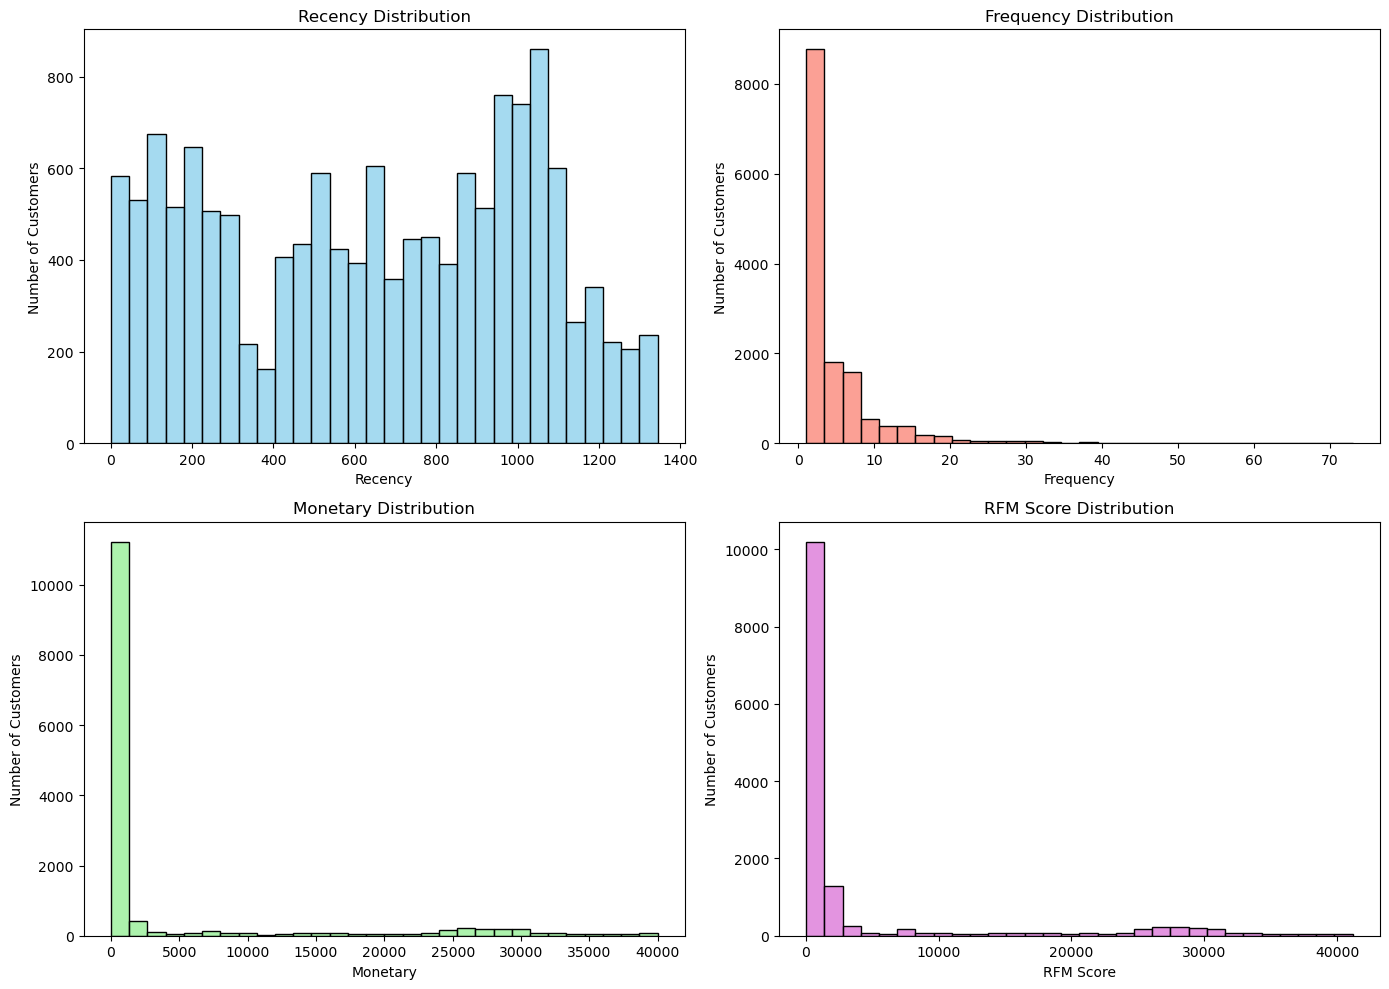

In [132]:
# 创建图形
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Recency分布图
sns.histplot(filtered_rfm['Recency'], kde=False, ax=ax[0, 0], bins=30, color='skyblue')
ax[0, 0].set_title('Recency Distribution')
ax[0, 0].set_xlabel('Recency')
ax[0, 0].set_ylabel('Number of Customers')

# Frequency分布图
sns.histplot(filtered_rfm['Frequency'], kde=False, ax=ax[0, 1], bins=30, color='salmon')
ax[0, 1].set_title('Frequency Distribution')
ax[0, 1].set_xlabel('Frequency')
ax[0, 1].set_ylabel('Number of Customers')

# Monetary分布图
sns.histplot(filtered_rfm['Monetary'], kde=False, ax=ax[1, 0], bins=30, color='lightgreen')
ax[1, 0].set_title('Monetary Distribution')
ax[1, 0].set_xlabel('Monetary')
ax[1, 0].set_ylabel('Number of Customers')

# RFM得分分布图 (需要计算RFM得分)
filtered_rfm['RFM_Score'] = filtered_rfm['Recency'] + filtered_rfm['Frequency'] + filtered_rfm['Monetary']
sns.histplot(filtered_rfm['RFM_Score'], kde=False, ax=ax[1, 1], bins=30, color='orchid')
ax[1, 1].set_title('RFM Score Distribution')
ax[1, 1].set_xlabel('RFM Score')
ax[1, 1].set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()

In [133]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14664 entries, 452485 to 545022
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    14664 non-null  int64  
 1   Frequency  14664 non-null  int64  
 2   Monetary   14664 non-null  float64
 3   Cluster    14664 non-null  int64  
 4   RFM_Score  14664 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 687.4 KB


In [134]:
filtered_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14161 entries, 452485 to 545022
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    14161 non-null  int64  
 1   Frequency  14161 non-null  int64  
 2   Monetary   14161 non-null  float64
 3   Cluster    14161 non-null  int64  
 4   RFM_Score  14161 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 663.8 KB


In [135]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 复制筛选后的数据，避免直接对原数据进行修改
filtered_rfm = rfm[rfm['Monetary'] <= 40000].copy()

# Step 1: Data preprocessing 
rfm_values = filtered_rfm[['Recency', 'Frequency', 'Monetary']].values
rfm_scaled_values = scaler.transform(rfm_values)

# Step 2: Run K-means clustering
k = 5 # 此处是为了简化演示处理，便临时取值为5
kmeans = KMeans(n_clusters=k, random_state=42)
filtered_rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled_values)

# Step 3: Evaluate the clusters
silhouette_avg = silhouette_score(rfm_scaled_values, filtered_rfm['KMeans_Cluster'])

# Cluster counts and silhouette score
cluster_counts = filtered_rfm['KMeans_Cluster'].value_counts()
cluster_counts, silhouette_avg

(1    6456
 3    4903
 4    1549
 0     988
 2     265
 Name: KMeans_Cluster, dtype: int64,
 0.502349752910309)

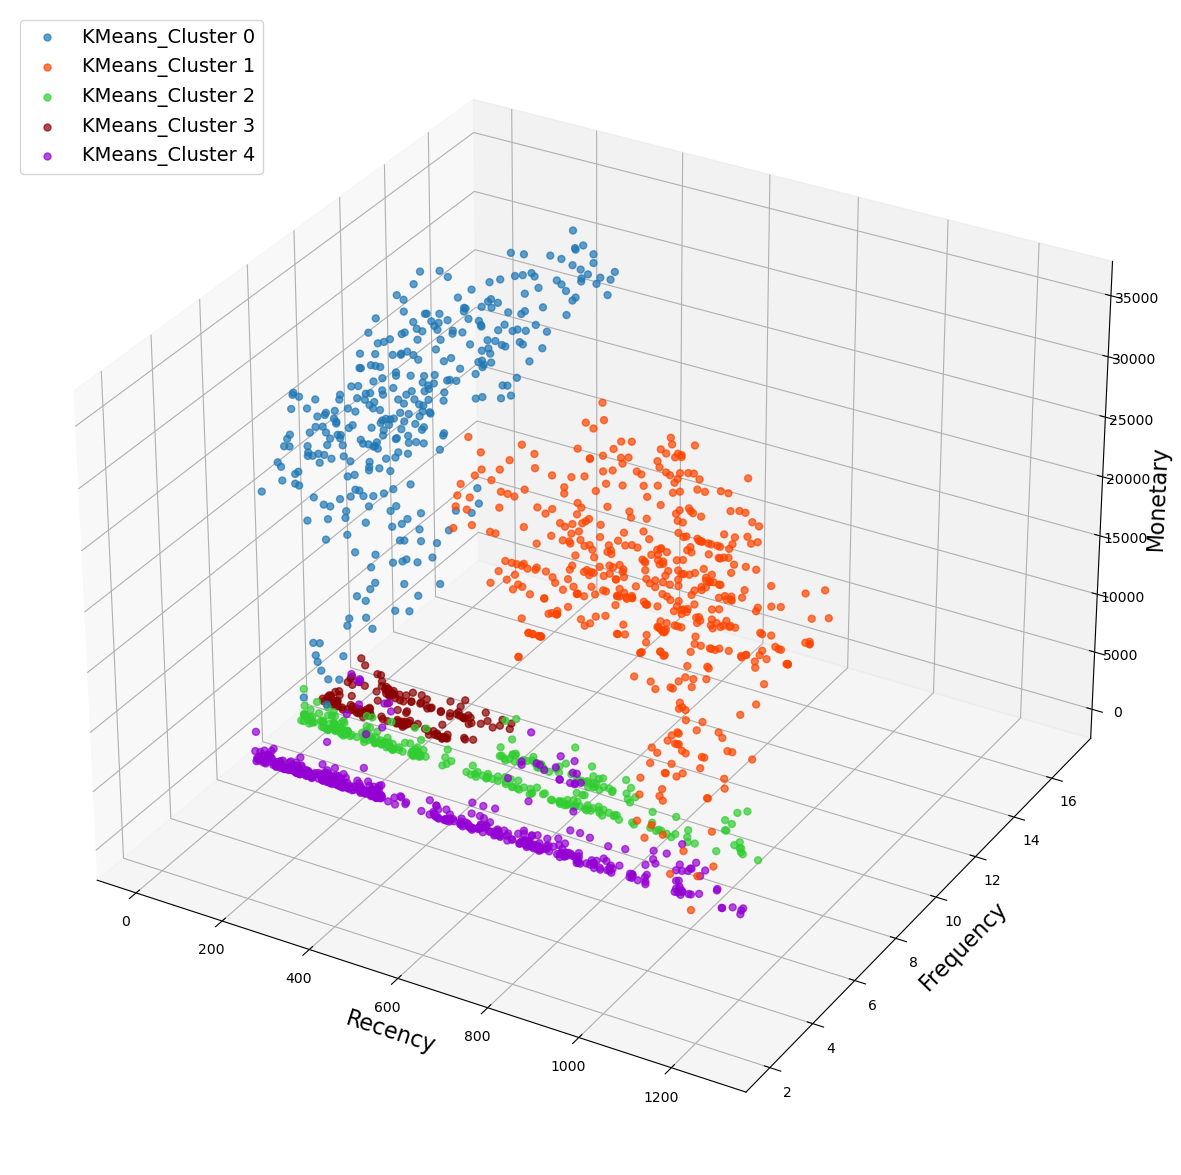

In [136]:
# 对KMeans结果进行3D可视化处理

# 使用更为鲜明的颜色组合
colors = [
    "#1f77b4", "#ff4500", "#32cd32", "#8b0000", "#9400d3",
    "#ff1493", "#d2691e", "#00ced1", "#ff69b4", "#ffd700",
    "#adff2f", "#ffa500", "#4b0082"
]

# 进一步增加透明度
alpha_value = 0.7

# 保持点的大小
sizes = {cluster: 25 for cluster in filtered_rfm['KMeans_Cluster'].unique()}

fig = plt.figure(figsize=(20, 15))
dx = fig.add_subplot(111, projection='3d')

for i, label in enumerate(sorted(filtered_rfm['KMeans_Cluster'].unique())):
    dx.scatter(filtered_rfm[filtered_rfm.Cluster == label].Recency,
               filtered_rfm[filtered_rfm.Cluster == label].Frequency,
               filtered_rfm[filtered_rfm.Cluster == label].Monetary,
               c=[colors[i]],
               label='KMeans_Cluster ' + str(label),
               s=sizes[label], alpha=alpha_value)

dx.set_xlabel('Recency', fontsize=16)
dx.set_ylabel('Frequency', fontsize=16)
dx.set_zlabel('Monetary', fontsize=16)
dx.legend(fontsize=14, loc='upper left')
dx.grid(True)  # 保持网格
plt.show()